# Tutorial 04: Granger Causality Testing

**Level:** Intermediate-Advanced  
**Estimated Duration:** 90-120 minutes  
**Prerequisites:** Tutorials 01-03 (Panel VAR estimation, lag selection, stability analysis)

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Understand** the formal definition and limitations of Granger causality
2. **Apply** the standard homogeneous Wald test for pairwise Granger causality
3. **Construct** and interpret the full Granger causality matrix (K x K)
4. **Implement** the Dumitrescu-Hurlin (2012) test for heterogeneous panels
5. **Visualize** causal networks using directed graphs (networkx)
6. **Distinguish** between lagged (Granger) and instantaneous (contemporaneous) causality
7. **Apply** best practices including multiple testing correction and sensitivity analysis

## Table of Contents

| Section | Topic | Duration |
|---------|-------|----------|
| 1 | Granger Causality Concept | 15 min |
| 2 | Standard Granger Test (Wald) | 20 min |
| 3 | Granger Causality Matrix | 15 min |
| 4 | Dumitrescu-Hurlin Test | 30 min |
| 5 | Causality Network Visualization | 20 min |
| 6 | Instantaneous Causality | 15 min |
| 7 | Best Practices and Pitfalls | 15 min |
| - | Exercises | - |

---

## Setup

In [1]:
# Standard imports
import sys
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
from scipy import stats

# PanelBox imports
from panelbox.var import PanelVARData, PanelVAR, plot_causality_network

# Tutorial utilities
sys.path.insert(0, '../utils')
from data_generators import generate_trade_panel
from diagnostic_tools import granger_causality_summary

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 7),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 100,
})
sns.set_palette('colorblind')

# Suppress non-critical warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

# Output directories
FIGURES_DIR = '../outputs/figures/causality_networks'
TABLES_DIR = '../outputs/tables'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# Reproducibility
np.random.seed(42)

print('Setup complete.')
print(f'Figures will be saved to: {os.path.abspath(FIGURES_DIR)}')
print(f'Tables will be saved to: {os.path.abspath(TABLES_DIR)}')

Setup complete.
Figures will be saved to: /home/guhaase/projetos/panelbox/examples/var/outputs/figures/causality_networks
Tables will be saved to: /home/guhaase/projetos/panelbox/examples/var/outputs/tables


---

## Section 1: Granger Causality Concept (15 min)

### 1.1 Definition

**Granger causality** (Granger, 1969) formalizes the intuitive idea of predictive causation:

> Variable $X$ **Granger-causes** variable $Y$ if and only if past values of $X$ contain information that helps predict $Y$ **beyond** what is already contained in past values of $Y$ itself.

In the context of a VAR(p) model:

$$Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \cdots + A_p Y_{t-p} + u_t$$

The test for whether variable $j$ Granger-causes variable $i$ is:

$$H_0: A_1[i,j] = A_2[i,j] = \cdots = A_p[i,j] = 0$$

That is, **all** lag coefficients of $X_j$ in the equation for $Y_i$ are jointly zero.

### 1.2 Three Possible Outcomes

For any pair of variables $(X, Y)$, there are three possible patterns:

| Pattern | X causes Y? | Y causes X? | Interpretation |
|---------|:-----------:|:-----------:|----------------|
| **Unidirectional** | Yes | No | X predicts Y, but not vice versa |
| **Bidirectional (Feedback)** | Yes | Yes | Each variable helps predict the other |
| **Independence** | No | No | Neither variable helps predict the other |

### 1.3 Critical Interpretation Warning

**"Granger-causes" does NOT mean "causes" in the structural or philosophical sense.**

- Granger causality is purely about **predictive content** in time series
- It is possible for $X$ to Granger-cause $Y$ even when $X$ has no structural effect on $Y$ (e.g., because both respond to a common latent factor with different delays)
- Omitted variables can lead to spurious Granger causality
- The results are conditional on the information set (variables included in the VAR)

### 1.4 Load Data and Estimate VAR

We use the macro panel dataset with 30 countries and 40 quarters. The VAR includes five macroeconomic variables: GDP growth, inflation, interest rate, unemployment, and exchange rate.

In [2]:
# Load macro panel data
df = pd.read_csv('../data/macro_panel.csv')

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')

print(f'Dataset shape: {df.shape}')
print(f'Countries: {df["country"].nunique()}')
print(f'Quarters: {df["quarter"].nunique()}')
print(f'\nColumns: {list(df.columns)}')
print(f'\nSample data:')
df.head(8)

Dataset shape: (1200, 7)
Countries: 30
Quarters: 40

Columns: ['country', 'quarter', 'gdp_growth', 'inflation', 'interest_rate', 'unemployment', 'exchange_rate']

Sample data:


,country,quarter,gdp_growth,inflation,interest_rate,unemployment,exchange_rate
0,USA,2010Q1,0.692341,4.189052,5.030471,12.376956,98.170049
1,USA,2010Q2,0.387922,3.090266,1.703063,10.128024,97.349193
2,USA,2010Q3,0.451509,4.755641,1.420913,10.607511,97.377636
3,USA,2010Q4,3.727293,2.010963,4.140729,9.955421,95.618850
4,USA,2011Q1,3.520028,3.021079,3.300164,9.393912,96.046546
5,USA,2011Q2,3.326623,3.912270,5.771622,7.995519,99.969805
6,USA,2011Q3,0.378482,2.893708,6.113115,10.331220,97.770373
7,USA,2011Q4,1.309133,2.032529,5.094521,11.720063,98.526679


In [3]:
# Prepare data for Panel VAR
endog_vars = ['gdp_growth', 'inflation', 'interest_rate', 'unemployment', 'exchange_rate']

var_data = PanelVARData(
    df,
    endog_vars=endog_vars,
    entity_col='country',
    time_col='quarter',
    lags=2,
)

# Estimate Panel VAR
model = PanelVAR(var_data)
results = model.fit(method='ols', cov_type='clustered')

print(f'Panel VAR({results.p}) estimated successfully')
print(f'  Variables (K): {results.K}')
print(f'  Entities (N):  {results.N}')
print(f'  Observations:  {results.n_obs}')
print(f'  Stable:        {results.is_stable()}')

Panel VAR(2) estimated successfully
  Variables (K): 5
  Entities (N):  30
  Observations:  1140
  Stable:        True


---

## Section 2: Standard Granger Causality Test (20 min)

The **standard (homogeneous) Granger test** is a Wald test that constrains all lag coefficients of the cause variable in the effect equation to zero. It assumes that the relationship is the same across all entities (pooled coefficients).

### Test Statistic

$$W = (R\hat{\beta})^\prime \left[ R \cdot \text{Var}(\hat{\beta}) \cdot R^\prime \right]^{-1} (R\hat{\beta}) \sim \chi^2(p)$$

where $R$ is the restriction matrix that selects the $p$ lag coefficients of the causing variable.

### 2.1 Test a Single Pair: Inflation -> GDP Growth

Does inflation help predict GDP growth? A positive result would suggest that lagged inflation contains information useful for forecasting GDP growth.

In [4]:
# Test: Does inflation Granger-cause GDP growth?
gc_inf_gdp = results.granger_causality(cause='inflation', effect='gdp_growth')

# Display the full summary
print(gc_inf_gdp.summary())

Granger Causality Test
Null Hypothesis: inflation does not Granger-cause gdp_growth

Causing variable:  inflation
Effect variable:   gdp_growth
Lags tested:       2

Test Statistics:
  Wald statistic:      2.7267
  F-statistic:         1.3634
  Degrees of freedom: 2
  P-value (χ²):        0.2558
  P-value (F):         0.2562

Conclusion: Fails to reject H0: inflation does not Granger-cause gdp_growth


In [5]:
# Access individual attributes
print(f'Cause:          {gc_inf_gdp.cause}')
print(f'Effect:         {gc_inf_gdp.effect}')
print(f'Wald statistic: {gc_inf_gdp.wald_stat:.4f}')
print(f'F-statistic:    {gc_inf_gdp.f_stat:.4f}')
print(f'Degrees of freedom: {gc_inf_gdp.df}')
print(f'P-value:        {gc_inf_gdp.p_value:.6f}')
print(f'Conclusion:     {gc_inf_gdp.conclusion}')

Cause:          inflation
Effect:         gdp_growth
Wald statistic: 2.7267
F-statistic:    1.3634
Degrees of freedom: 2
P-value:        0.255798
Conclusion:     Fails to reject H0: inflation does not Granger-cause gdp_growth


### 2.2 Test the Reverse Direction: GDP Growth -> Inflation

Granger causality is **directional** -- the result can differ depending on which variable is cause and which is effect. Let us test the reverse direction.

In [6]:
# Test the reverse: Does GDP growth Granger-cause inflation?
gc_gdp_inf = results.granger_causality(cause='gdp_growth', effect='inflation')
print(gc_gdp_inf.summary())

print('\n--- Comparison ---')
print(f'Inflation -> GDP growth:  Wald = {gc_inf_gdp.wald_stat:.2f}, p = {gc_inf_gdp.p_value:.4f}')
print(f'GDP growth -> Inflation:  Wald = {gc_gdp_inf.wald_stat:.2f}, p = {gc_gdp_inf.p_value:.4f}')

# Classify the relationship
alpha = 0.05
inf_causes_gdp = gc_inf_gdp.p_value < alpha
gdp_causes_inf = gc_gdp_inf.p_value < alpha

if inf_causes_gdp and gdp_causes_inf:
    pattern = 'Bidirectional (feedback)'
elif inf_causes_gdp:
    pattern = 'Unidirectional: Inflation -> GDP Growth'
elif gdp_causes_inf:
    pattern = 'Unidirectional: GDP Growth -> Inflation'
else:
    pattern = 'Independent (no Granger causality in either direction)'

print(f'\nRelationship pattern at {alpha*100:.0f}% level: {pattern}')

Granger Causality Test
Null Hypothesis: gdp_growth does not Granger-cause inflation

Causing variable:  gdp_growth
Effect variable:   inflation
Lags tested:       2

Test Statistics:
  Wald statistic:      7.9250
  F-statistic:         3.9625
  Degrees of freedom: 2
  P-value (χ²):        0.0190
  P-value (F):         0.0193

Conclusion: Rejects H0 at 5%: gdp_growth Granger-causes inflation (**)

--- Comparison ---
Inflation -> GDP growth:  Wald = 2.73, p = 0.2558
GDP growth -> Inflation:  Wald = 7.93, p = 0.0190

Relationship pattern at 5% level: Unidirectional: GDP Growth -> Inflation


### 2.3 Test Multiple Pairs Systematically

Let us test several economically interesting causal hypotheses.

In [7]:
# Define economically interesting pairs to test
test_pairs = [
    ('inflation', 'interest_rate', 'Taylor rule: central bank responds to inflation'),
    ('interest_rate', 'gdp_growth', 'Monetary transmission: rates affect output'),
    ('gdp_growth', 'unemployment', 'Okun\'s law: output affects employment'),
    ('interest_rate', 'exchange_rate', 'Uncovered interest parity'),
    ('exchange_rate', 'inflation', 'Exchange rate pass-through'),
    ('gdp_growth', 'inflation', 'Phillips curve: output gap and inflation'),
    ('unemployment', 'inflation', 'Wage-price spiral'),
    ('exchange_rate', 'gdp_growth', 'Trade channel of exchange rates'),
]

# Run all tests and collect results
pair_results = []
for cause, effect, label in test_pairs:
    gc = results.granger_causality(cause=cause, effect=effect)
    pair_results.append({
        'Cause': cause,
        'Effect': effect,
        'Hypothesis': label,
        'Wald': gc.wald_stat,
        'F-stat': gc.f_stat,
        'p-value': gc.p_value,
        'Significant (5%)': gc.p_value < 0.05,
    })

pair_df = pd.DataFrame(pair_results)
pair_df = pair_df.sort_values('p-value').reset_index(drop=True)

# Display with formatting
print('Pairwise Granger Causality Tests (sorted by p-value):')
print('=' * 95)
for _, row in pair_df.iterrows():
    stars = '***' if row['p-value'] < 0.01 else '**' if row['p-value'] < 0.05 else '*' if row['p-value'] < 0.10 else ''
    print(f"  {row['Cause']:>16s} -> {row['Effect']:<16s}  "
          f"Wald={row['Wald']:8.2f}  p={row['p-value']:.4f} {stars:<3s}  "
          f"({row['Hypothesis']})")
print('=' * 95)
print('Significance: *** p<0.01, ** p<0.05, * p<0.10')

Pairwise Granger Causality Tests (sorted by p-value):
         inflation -> interest_rate     Wald=  135.79  p=0.0000 ***  (Taylor rule: central bank responds to inflation)
        gdp_growth -> unemployment      Wald=   56.37  p=0.0000 ***  (Okun's law: output affects employment)
     interest_rate -> gdp_growth        Wald=   37.22  p=0.0000 ***  (Monetary transmission: rates affect output)
     interest_rate -> exchange_rate     Wald=   17.90  p=0.0001 ***  (Uncovered interest parity)
        gdp_growth -> inflation         Wald=    7.93  p=0.0190 **   (Phillips curve: output gap and inflation)
      unemployment -> inflation         Wald=    3.18  p=0.2040      (Wage-price spiral)
     exchange_rate -> inflation         Wald=    0.89  p=0.6422      (Exchange rate pass-through)
     exchange_rate -> gdp_growth        Wald=    0.39  p=0.8239      (Trade channel of exchange rates)
Significance: *** p<0.01, ** p<0.05, * p<0.10


---

## Section 3: Granger Causality Matrix (15 min)

Rather than testing pairs individually, we can compute the **full K x K matrix** of p-values for all pairwise Granger causality tests. Element $(i, j)$ gives the p-value for "variable $i$ Granger-causes variable $j$".

Diagonal elements are NaN because a variable does not Granger-cause itself in this context.

In [8]:
# Compute the full Granger causality matrix
gc_matrix = results.granger_causality_matrix(significance_level=0.05)

print('Granger Causality P-Value Matrix')
print('Element (i, j) = p-value for: "row i Granger-causes column j"')
print()

# Display with formatting
styled = gc_matrix.style.format('{:.4f}', na_rep='-').background_gradient(
    cmap='RdYlGn_r', vmin=0, vmax=0.10
)
styled

Granger Causality P-Value Matrix
Element (i, j) = p-value for: "row i Granger-causes column j"



,gdp_growth,inflation,interest_rate,unemployment,exchange_rate
gdp_growth,-,0.0190,0.0001,0.0000,0.0299
inflation,0.2558,-,0.0000,0.1406,0.2610
interest_rate,0.0000,0.2206,-,0.0173,0.0001
unemployment,0.9707,0.2040,0.6367,-,0.8976
exchange_rate,0.8239,0.6422,0.9038,0.7886,-


In [9]:
# Count significant relationships
significant_mask = gc_matrix < 0.05
n_significant = significant_mask.sum().sum()  # Count all True values
n_total = gc_matrix.notna().sum().sum()  # Total non-NaN values

print(f'Significant causal relationships at 5%: {n_significant} out of {n_total} pairs')
print(f'Percentage: {100 * n_significant / n_total:.1f}%')
print()

# List all significant pairs
print('Significant Granger-causal relationships (p < 0.05):')
for cause_var in gc_matrix.index:
    for effect_var in gc_matrix.columns:
        pval = gc_matrix.loc[cause_var, effect_var]
        if pd.notna(pval) and pval < 0.05:
            stars = '***' if pval < 0.01 else '**'
            print(f'  {cause_var:>16s} -> {effect_var:<16s}  p = {pval:.4f} {stars}')

Significant causal relationships at 5%: 8 out of 20 pairs
Percentage: 40.0%

Significant Granger-causal relationships (p < 0.05):
        gdp_growth -> inflation         p = 0.0190 **
        gdp_growth -> interest_rate     p = 0.0001 ***
        gdp_growth -> unemployment      p = 0.0000 ***
        gdp_growth -> exchange_rate     p = 0.0299 **
         inflation -> interest_rate     p = 0.0000 ***
     interest_rate -> gdp_growth        p = 0.0000 ***
     interest_rate -> unemployment      p = 0.0173 **
     interest_rate -> exchange_rate     p = 0.0001 ***


### 3.1 Heatmap Visualization

A heatmap provides an intuitive overview of the causality structure. Lower p-values (stronger evidence of causality) appear in warmer colors.

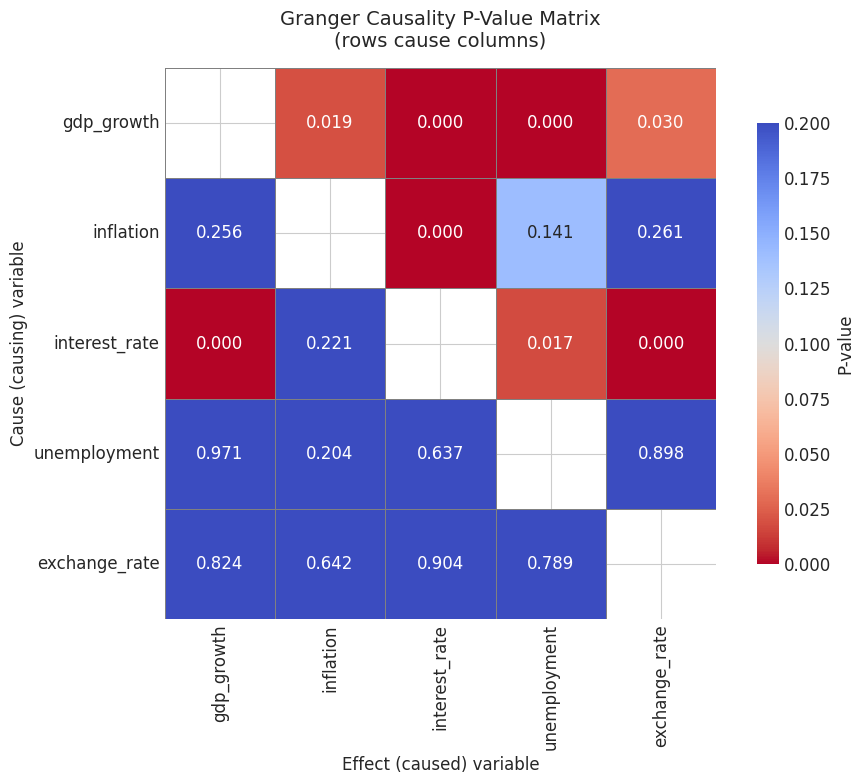

Heatmap and table saved.


In [10]:
# Create heatmap of Granger causality p-values
fig, ax = plt.subplots(figsize=(10, 8))

# Use coolwarm_r: blue = high p-value (no causality), red = low p-value (causality)
mask = gc_matrix.isna()  # Mask the diagonal
heatmap = sns.heatmap(
    gc_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm_r',
    vmin=0,
    vmax=0.20,
    mask=mask,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'P-value', 'shrink': 0.8},
    ax=ax,
)

ax.set_title('Granger Causality P-Value Matrix\n(rows cause columns)', fontsize=14, pad=15)
ax.set_xlabel('Effect (caused) variable', fontsize=12)
ax.set_ylabel('Cause (causing) variable', fontsize=12)

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, '04_granger_causality_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

# Save matrix as CSV table
gc_matrix.to_csv(os.path.join(TABLES_DIR, '04_granger_causality_matrix.csv'))
print('Heatmap and table saved.')

### 3.2 Interpretation

Reading the heatmap:

- **Red/warm cells** indicate strong evidence of Granger causality (low p-value)
- **Blue/cool cells** indicate no evidence of causality (high p-value)
- **Rows** = cause variable, **Columns** = effect variable
- The matrix is generally **asymmetric**: X may Granger-cause Y without Y Granger-causing X

Key economic relationships to look for:

- **Taylor rule**: inflation -> interest_rate (central bank reacts to inflation)
- **Monetary transmission**: interest_rate -> gdp_growth (rates affect output)
- **Okun's law**: gdp_growth -> unemployment (output gap drives employment)

---

## Section 4: Dumitrescu-Hurlin Test (30 min)

### 4.1 Motivation: Heterogeneity Across Entities

The standard Granger test assumes **homogeneous** coefficients across all entities -- the same causal relationship holds with the same strength for every country. This is a strong assumption.

The **Dumitrescu-Hurlin (2012)** test allows for **heterogeneous** coefficients:

$$y_{i,t} = \alpha_i + \sum_{l=1}^p \gamma_{i,l} \, y_{i,t-l} + \sum_{l=1}^p \beta_{i,l} \, x_{i,t-l} + \varepsilon_{i,t}$$

Notice that the coefficients $\gamma_{i,l}$ and $\beta_{i,l}$ are **entity-specific** (subscript $i$).

### 4.2 DH Hypotheses

$$H_0: \beta_{i,1} = \beta_{i,2} = \cdots = \beta_{i,p} = 0 \quad \forall \, i = 1, \ldots, N$$

That is, **no entity** exhibits Granger causality. Under the alternative:

$$H_1: \exists \text{ at least one entity } i \text{ for which } x \text{ Granger-causes } y$$

### 4.3 DH Test Procedure

1. For each entity $i$, estimate the individual regression and compute $W_i$ (Wald statistic)
2. Compute the average: $\bar{W} = \frac{1}{N} \sum_{i=1}^N W_i$
3. Compute two standardized statistics:
   - $\tilde{Z} = \sqrt{\frac{N}{2p}} (\bar{W} - p) \xrightarrow{d} N(0,1)$ for $T$ fixed, $N \to \infty$
   - $\bar{Z} = \sqrt{N} \cdot \frac{\bar{W} - E[W_{i,T}]}{\sqrt{\text{Var}(W_{i,T})}} \xrightarrow{d} N(0,1)$ for $T \to \infty$, $N \to \infty$

The recommended statistic depends on the panel dimensions:
- $T$ small, $N$ large: use $\tilde{Z}$
- $T$ and $N$ both large: use $\bar{Z}$ (finite-sample corrected)

### 4.4 Implementation

**Note:** The DH test re-estimates individual regressions for each entity, so it may take a moment to run.

In [11]:
# Dumitrescu-Hurlin test: Does inflation Granger-cause GDP growth (heterogeneous)?
dh_inf_gdp = results.dumitrescu_hurlin(cause='inflation', effect='gdp_growth')

# Display full summary
print(dh_inf_gdp.summary())

Dumitrescu-Hurlin (2012) Panel Granger Causality Test
Null Hypothesis: inflation does not Granger-cause gdp_growth for any entity (homogeneous non-causality)

Alternative: Granger causality for at least some entities

Causing variable:  inflation
Effect variable:   gdp_growth
Number of entities (N):  30
Average time periods (T̄): 40.0
Lags tested (p):         2

Test Statistics:
  W̄ (Average Wald):           2.1318

  Z̃ statistic (T fixed):      0.3611
  Z̃ p-value:                  0.7180

  Z̄ statistic (T→∞):          0.3500
  Z̄ p-value:                  0.7264

Recommended: Use Z_bar

Conclusion: Fails to reject H0: No evidence of Granger causality

Individual Entity Statistics:
  Min W_i:         0.1369
  Mean W_i:        2.1318
  Median W_i:      1.0030
  Max W_i:        20.4435
  Std W_i:         3.6033



In [12]:
# Access individual attributes of the DH result
print(f'Cause:             {dh_inf_gdp.cause}')
print(f'Effect:            {dh_inf_gdp.effect}')
print(f'W_bar:             {dh_inf_gdp.W_bar:.4f}')
print(f'Z_tilde stat:      {dh_inf_gdp.Z_tilde_stat:.4f}')
print(f'Z_tilde p-value:   {dh_inf_gdp.Z_tilde_pvalue:.4f}')
print(f'Z_bar stat:        {dh_inf_gdp.Z_bar_stat:.4f}')
print(f'Z_bar p-value:     {dh_inf_gdp.Z_bar_pvalue:.4f}')
print(f'Recommended stat:  {dh_inf_gdp.recommended_stat}')
print(f'N (entities):      {dh_inf_gdp.N}')
print(f'T_avg:             {dh_inf_gdp.T_avg:.1f}')
print(f'Lags:              {dh_inf_gdp.lags}')
print(f'Individual W stats: {len(dh_inf_gdp.individual_W)} values')
print(f'  Min:  {dh_inf_gdp.individual_W.min():.4f}')
print(f'  Mean: {dh_inf_gdp.individual_W.mean():.4f}')
print(f'  Max:  {dh_inf_gdp.individual_W.max():.4f}')

Cause:             inflation
Effect:            gdp_growth
W_bar:             2.1318
Z_tilde stat:      0.3611
Z_tilde p-value:   0.7180
Z_bar stat:        0.3500
Z_bar p-value:     0.7264
Recommended stat:  Z_bar
N (entities):      30
T_avg:             40.0
Lags:              2
Individual W stats: 30 values
  Min:  0.1369
  Mean: 2.1318
  Max:  20.4435


### 4.5 Distribution of Individual Wald Statistics

The DH test is based on averaging individual Wald statistics $W_i$ across entities. Visualizing their distribution reveals heterogeneity: do all countries show similar evidence of causality, or is the result driven by a few outlier countries?

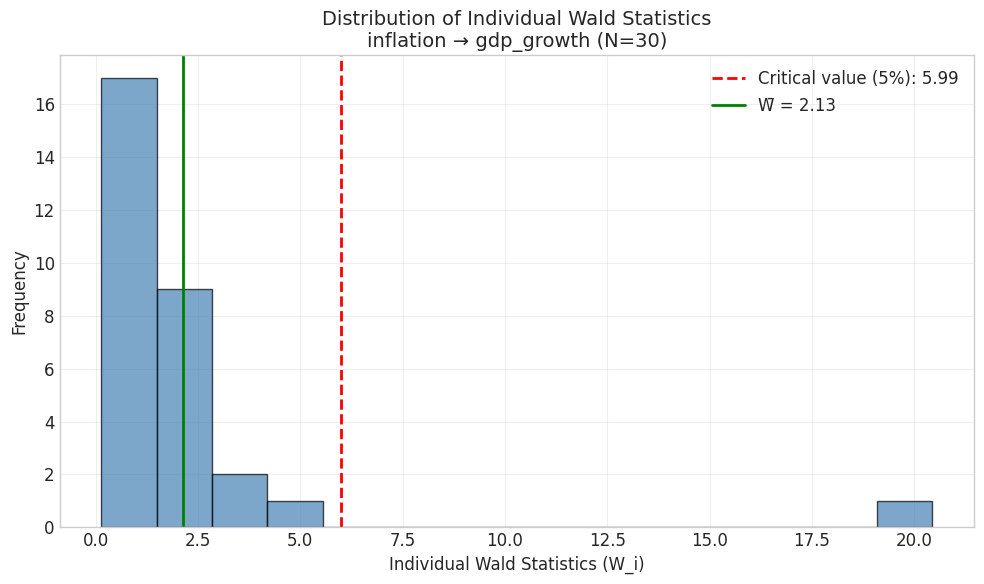

Distribution plot saved.


In [13]:
# Plot distribution of individual Wald statistics
fig = dh_inf_gdp.plot_individual_statistics(backend='matplotlib', show=False)

fig.savefig(os.path.join(FIGURES_DIR, '04_dh_individual_wald_inflation_gdp.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('Distribution plot saved.')

### 4.6 DH Tests for Key Economic Relationships

In [14]:
# Run DH tests for the same economic hypotheses as above
dh_pairs = [
    ('inflation', 'interest_rate'),
    ('interest_rate', 'gdp_growth'),
    ('gdp_growth', 'unemployment'),
    ('interest_rate', 'exchange_rate'),
    ('gdp_growth', 'inflation'),
]

dh_results_list = []
for cause, effect in dh_pairs:
    dh = results.dumitrescu_hurlin(cause=cause, effect=effect)
    
    # Use recommended statistic
    if dh.recommended_stat == 'Z_tilde':
        z_stat, z_pval = dh.Z_tilde_stat, dh.Z_tilde_pvalue
    else:
        z_stat, z_pval = dh.Z_bar_stat, dh.Z_bar_pvalue
    
    dh_results_list.append({
        'Cause': cause,
        'Effect': effect,
        'W_bar': dh.W_bar,
        'Recommended': dh.recommended_stat,
        'Z_stat': z_stat,
        'p-value': z_pval,
        'Significant (5%)': z_pval < 0.05,
    })

dh_df = pd.DataFrame(dh_results_list)
dh_df = dh_df.sort_values('p-value').reset_index(drop=True)

print('Dumitrescu-Hurlin Granger Causality Tests (heterogeneous):')
print('=' * 85)
for _, row in dh_df.iterrows():
    stars = '***' if row['p-value'] < 0.01 else '**' if row['p-value'] < 0.05 else '*' if row['p-value'] < 0.10 else ''
    print(f"  {row['Cause']:>16s} -> {row['Effect']:<16s}  "
          f"W_bar={row['W_bar']:7.2f}  Z={row['Z_stat']:7.2f}  "
          f"p={row['p-value']:.4f} {stars:<3s}  [{row['Recommended']}]")
print('=' * 85)

Dumitrescu-Hurlin Granger Causality Tests (heterogeneous):
         inflation -> interest_rate     W_bar=   6.25  Z=  11.28  p=0.0000 ***  [Z_bar]
     interest_rate -> gdp_growth        W_bar=   5.46  Z=   9.18  p=0.0000 ***  [Z_bar]
        gdp_growth -> unemployment      W_bar=   5.22  Z=   8.53  p=0.0000 ***  [Z_bar]
     interest_rate -> exchange_rate     W_bar=   3.36  Z=   3.61  p=0.0003 ***  [Z_bar]
        gdp_growth -> inflation         W_bar=   2.11  Z=   0.28  p=0.7787      [Z_bar]


### 4.7 Comparing Standard Wald vs Dumitrescu-Hurlin

The standard Wald test and the DH test can give different results because they test different hypotheses:

| Feature | Standard Wald | Dumitrescu-Hurlin |
|---------|:---:|:---:|
| Coefficients | Homogeneous | Heterogeneous (entity-specific) |
| H0 | Pooled lag coefficients are zero | All individual lag coefficients are zero |
| H1 | Pooled lag coefficients are non-zero | At least one entity has non-zero coefficients |
| Power | Higher if homogeneity holds | Higher if heterogeneity is present |

In [15]:
# Direct comparison: Standard Wald vs DH for selected pairs
comparison_pairs = [
    ('inflation', 'interest_rate'),
    ('interest_rate', 'gdp_growth'),
    ('gdp_growth', 'unemployment'),
    ('gdp_growth', 'inflation'),
    ('interest_rate', 'exchange_rate'),
]

comparison_rows = []
for cause, effect in comparison_pairs:
    gc = results.granger_causality(cause=cause, effect=effect)
    dh = results.dumitrescu_hurlin(cause=cause, effect=effect)
    
    if dh.recommended_stat == 'Z_tilde':
        dh_pval = dh.Z_tilde_pvalue
    else:
        dh_pval = dh.Z_bar_pvalue
    
    comparison_rows.append({
        'Pair': f'{cause} -> {effect}',
        'Wald_stat': gc.wald_stat,
        'Wald_pval': gc.p_value,
        'DH_W_bar': dh.W_bar,
        'DH_pval': dh_pval,
        'Wald_sig': gc.p_value < 0.05,
        'DH_sig': dh_pval < 0.05,
        'Agree': (gc.p_value < 0.05) == (dh_pval < 0.05),
    })

comp_df = pd.DataFrame(comparison_rows)

print('Comparison: Standard Wald vs Dumitrescu-Hurlin')
print('=' * 90)
print(f'{"Pair":<35s} {"Wald p":>8s} {"DH p":>8s} {"Wald sig":>9s} {"DH sig":>7s} {"Agree":>6s}')
print('-' * 90)
for _, row in comp_df.iterrows():
    print(f"{row['Pair']:<35s} {row['Wald_pval']:>8.4f} {row['DH_pval']:>8.4f} "
          f"{str(row['Wald_sig']):>9s} {str(row['DH_sig']):>7s} {str(row['Agree']):>6s}")
print('=' * 90)

n_agree = comp_df['Agree'].sum()
print(f'\nAgreement rate: {n_agree}/{len(comp_df)} pairs agree on significance at 5%')

Comparison: Standard Wald vs Dumitrescu-Hurlin
Pair                                  Wald p     DH p  Wald sig  DH sig  Agree
------------------------------------------------------------------------------------------
inflation -> interest_rate            0.0000   0.0000      True    True   True
interest_rate -> gdp_growth           0.0000   0.0000      True    True   True
gdp_growth -> unemployment            0.0000   0.0000      True    True   True
gdp_growth -> inflation               0.0190   0.7787      True   False  False
interest_rate -> exchange_rate        0.0001   0.0003      True    True   True

Agreement rate: 4/5 pairs agree on significance at 5%


---

## Section 5: Causality Network Visualization (20 min)

A **causality network** (directed graph) provides an intuitive visualization of which variables Granger-cause which others. Nodes represent variables and directed edges represent significant causal relationships.

### 5.1 Built-in Network Plot

PanelBox provides a `plot_causality_network` method on the results object that automatically constructs and displays the network.

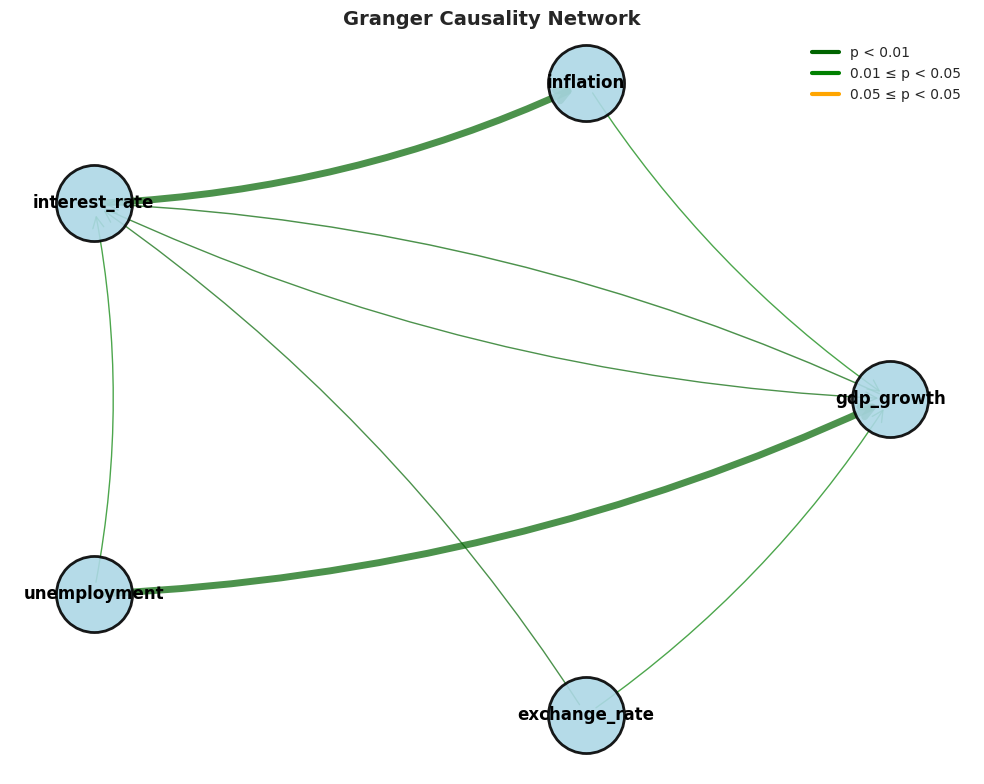

Circular network plot saved.


In [16]:
# Built-in causality network plot (circular layout)
fig = results.plot_causality_network(
    threshold=0.05,
    layout='circular',
    backend='matplotlib',
    show=False,
)

fig.savefig(os.path.join(FIGURES_DIR, '04_causality_network_circular.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('Circular network plot saved.')

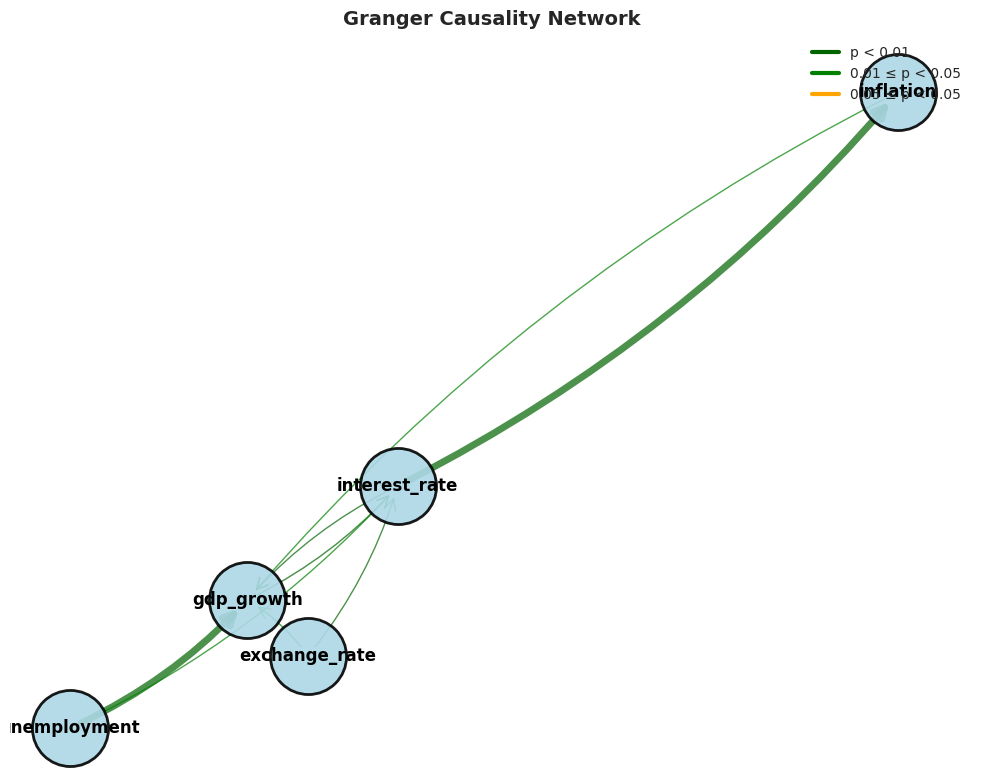

Spring network plot saved.


In [17]:
# Spring layout -- force-directed, useful for seeing clusters
fig = results.plot_causality_network(
    threshold=0.05,
    layout='spring',
    backend='matplotlib',
    show=False,
)

fig.savefig(os.path.join(FIGURES_DIR, '04_causality_network_spring.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('Spring network plot saved.')

### 5.2 Standalone Function with Custom Matrix

The `plot_causality_network` function can also be used as a standalone function with any p-value matrix.

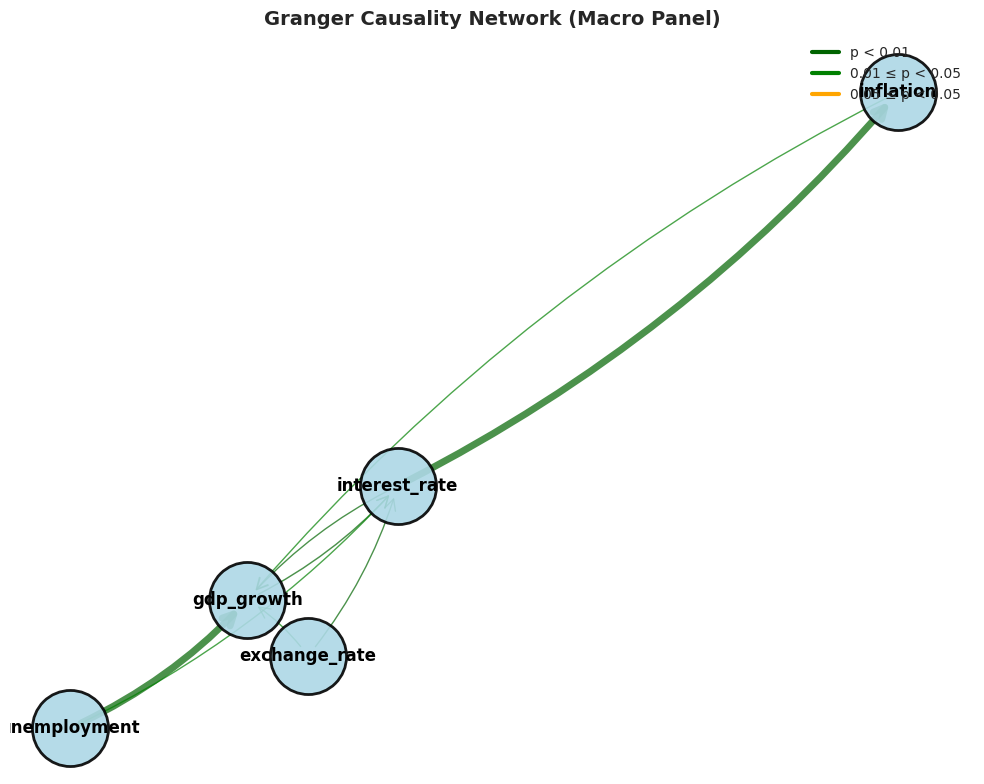

In [18]:
# Standalone function with our already-computed gc_matrix
fig = plot_causality_network(
    gc_matrix,
    threshold=0.05,
    layout='spring',
    backend='matplotlib',
    show=False,
    title='Granger Causality Network (Macro Panel)',
)

plt.show()

### 5.3 Manual Network Construction with NetworkX

For full customization, we can build the network manually using NetworkX. This is useful when you want to control node colors, edge styles, or add additional annotations.

In [19]:
# Build a directed graph manually from the Granger causality matrix
G = nx.DiGraph()

# Add all variables as nodes
variables = gc_matrix.index.tolist()
G.add_nodes_from(variables)

# Add edges for significant causal relationships (p < 0.05)
threshold = 0.05
edge_data = []

for cause_var in variables:
    for effect_var in variables:
        if cause_var == effect_var:
            continue
        pval = gc_matrix.loc[cause_var, effect_var]
        if pd.notna(pval) and pval < threshold:
            # Edge weight proportional to evidence strength
            weight = 1 - pval  # Higher weight = stronger evidence
            G.add_edge(cause_var, effect_var, p_value=pval, weight=weight)
            edge_data.append((cause_var, effect_var, pval))

print(f'Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} directed edges')
print(f'\nSignificant edges:')
for cause_var, effect_var, pval in sorted(edge_data, key=lambda x: x[2]):
    print(f'  {cause_var:>16s} -> {effect_var:<16s}  p = {pval:.4f}')

Network: 5 nodes, 8 directed edges

Significant edges:
         inflation -> interest_rate     p = 0.0000
        gdp_growth -> unemployment      p = 0.0000
     interest_rate -> gdp_growth        p = 0.0000
        gdp_growth -> interest_rate     p = 0.0001
     interest_rate -> exchange_rate     p = 0.0001
     interest_rate -> unemployment      p = 0.0173
        gdp_growth -> inflation         p = 0.0190
        gdp_growth -> exchange_rate     p = 0.0299


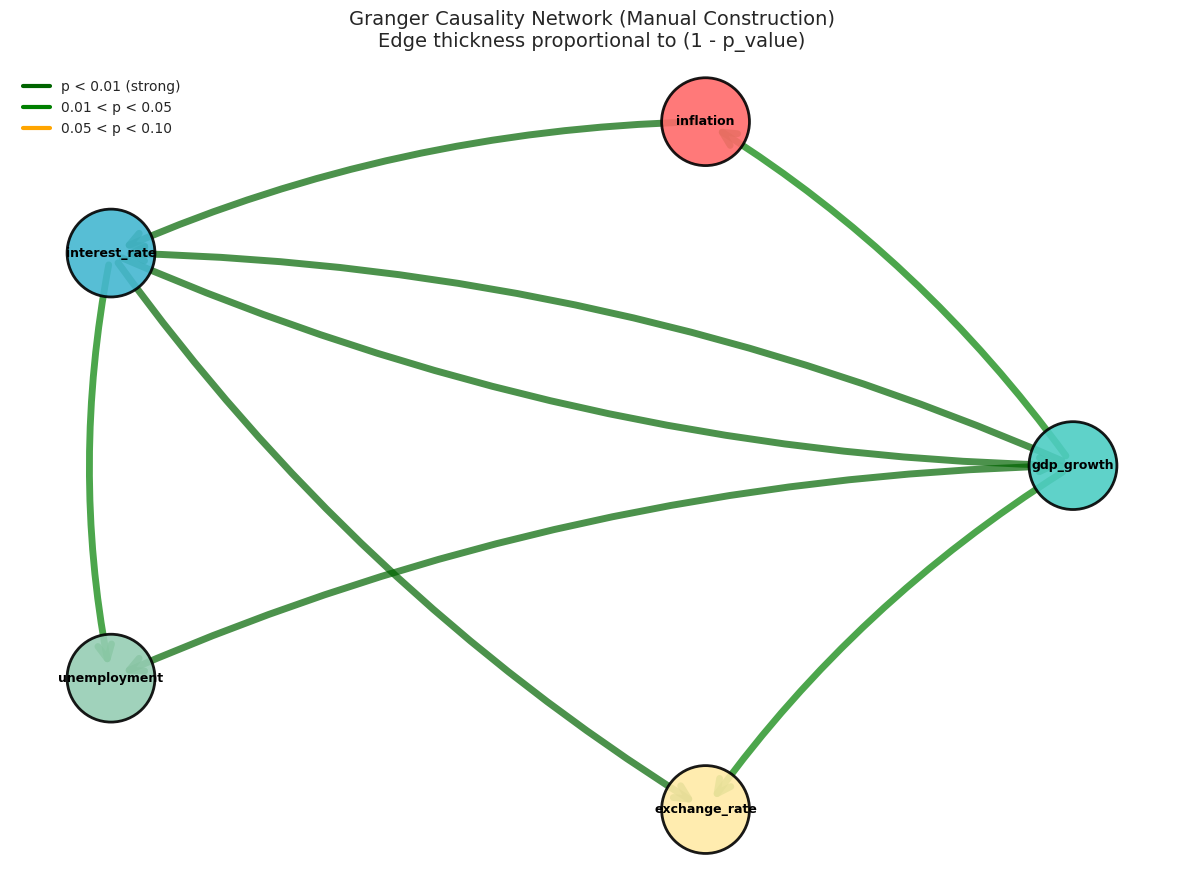

Manual network plot saved.


In [20]:
# Custom visualization of the causality network
fig, ax = plt.subplots(figsize=(12, 9))

# Layout
pos = nx.circular_layout(G)

# Draw nodes
node_colors = ['#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4', '#FFEAA7']
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors[:len(variables)],
    node_size=4000,
    alpha=0.9,
    edgecolors='black',
    linewidths=2,
    ax=ax,
)

# Draw node labels
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    ax=ax,
)

# Draw edges with thickness proportional to (1 - p_value)
if G.number_of_edges() > 0:
    for u, v in G.edges():
        pval = G[u][v]['p_value']
        width = 1.0 + 4.0 * (1 - pval)  # Wider = more significant
        color = 'darkgreen' if pval < 0.01 else 'green' if pval < 0.05 else 'orange'
        
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            edge_color=color,
            width=width,
            alpha=0.7,
            arrowsize=25,
            arrowstyle='->',
            connectionstyle='arc3,rad=0.1',
            ax=ax,
        )

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='darkgreen', linewidth=3, label='p < 0.01 (strong)'),
    Line2D([0], [0], color='green', linewidth=3, label='0.01 < p < 0.05'),
    Line2D([0], [0], color='orange', linewidth=3, label='0.05 < p < 0.10'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_title('Granger Causality Network (Manual Construction)\nEdge thickness proportional to (1 - p_value)',
             fontsize=14, pad=15)
ax.axis('off')

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, '04_causality_network_manual.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('Manual network plot saved.')

In [21]:
# Network centrality analysis
if G.number_of_edges() > 0:
    # In-degree: how many variables cause this one (effect centrality)
    in_degree = dict(G.in_degree())
    # Out-degree: how many variables does this one cause (cause centrality)
    out_degree = dict(G.out_degree())

    centrality_df = pd.DataFrame({
        'Variable': variables,
        'In-degree (caused by)': [in_degree.get(v, 0) for v in variables],
        'Out-degree (causes)': [out_degree.get(v, 0) for v in variables],
        'Total degree': [in_degree.get(v, 0) + out_degree.get(v, 0) for v in variables],
    }).sort_values('Total degree', ascending=False)

    print('Network Centrality Analysis')
    print('=' * 60)
    print(centrality_df.to_string(index=False))
    print('=' * 60)
    print()
    print('Interpretation:')
    most_influential = centrality_df.iloc[0]['Variable']
    print(f'  Most connected variable: {most_influential}')
    print(f'  (highest total degree in the Granger causality network)')
else:
    print('No significant edges in the network at the chosen threshold.')

Network Centrality Analysis
     Variable  In-degree (caused by)  Out-degree (causes)  Total degree
   gdp_growth                      1                    4             5
interest_rate                      2                    3             5
    inflation                      1                    1             2
 unemployment                      2                    0             2
exchange_rate                      2                    0             2

Interpretation:
  Most connected variable: gdp_growth
  (highest total degree in the Granger causality network)


---

## Section 6: Instantaneous Causality (15 min)

While Granger causality tests whether **lagged** values of $X$ help predict $Y$, **instantaneous causality** tests whether $X$ and $Y$ are contemporaneously correlated after accounting for all lagged dynamics.

Formally, it tests whether the residuals $\hat{u}_{i,t}$ and $\hat{u}_{j,t}$ from two VAR equations are correlated:

$$H_0: \text{Cov}(u_{i,t}, u_{j,t}) = 0 \quad \text{(no contemporaneous correlation)}$$

The test statistic is a likelihood ratio:

$$LR = -N \cdot T \cdot \log(1 - r^2) \sim \chi^2(1)$$

where $r$ is the sample correlation between the residuals.

### 6.1 Pairwise Instantaneous Causality

In [22]:
# Test for instantaneous causality between GDP growth and inflation
ic_gdp_inf = results.instantaneous_causality(var1='gdp_growth', var2='inflation')

print(ic_gdp_inf.summary())

Instantaneous Causality Test
Null Hypothesis: No contemporaneous correlation

Variable 1:  gdp_growth
Variable 2:  inflation

Correlation (r):          0.1534
LR statistic:            27.1313
P-value:                  0.0000
Observations:         1140

Conclusion: Rejects H0 at 1%: Significant contemporaneous correlation (***)


In [23]:
# Access attributes
print(f'Variable 1:    {ic_gdp_inf.var1}')
print(f'Variable 2:    {ic_gdp_inf.var2}')
print(f'Correlation:   {ic_gdp_inf.correlation:.4f}')
print(f'LR statistic:  {ic_gdp_inf.lr_stat:.4f}')
print(f'P-value:       {ic_gdp_inf.p_value:.6f}')
print(f'Observations:  {ic_gdp_inf.n_obs}')

Variable 1:    gdp_growth
Variable 2:    inflation
Correlation:   0.1534
LR statistic:  27.1313
P-value:       0.000000
Observations:  1140


### 6.2 Instantaneous Causality Matrix

In [24]:
# Compute the full instantaneous causality matrix
corr_matrix, pval_matrix = results.instantaneous_causality_matrix()

print('Residual Correlation Matrix:')
print(corr_matrix.round(3).to_string())
print()
print('Instantaneous Causality P-Values:')
print(pval_matrix.round(4).to_string())

Residual Correlation Matrix:
               gdp_growth  inflation  interest_rate  unemployment  exchange_rate
gdp_growth          1.000      0.153          0.044        -0.313          0.007
inflation           0.153      1.000          0.022        -0.025         -0.007
interest_rate       0.044      0.022          1.000         0.004          0.029
unemployment       -0.313     -0.025          0.004         1.000          0.043
exchange_rate       0.007     -0.007          0.029         0.043          1.000

Instantaneous Causality P-Values:
               gdp_growth  inflation  interest_rate  unemployment  exchange_rate
gdp_growth            NaN     0.0000         0.1339        0.0000         0.8157
inflation          0.0000        NaN         0.4626        0.3976         0.8130
interest_rate      0.1339     0.4626            NaN        0.8881         0.3297
unemployment       0.0000     0.3976         0.8881           NaN         0.1465
exchange_rate      0.8157     0.8130         

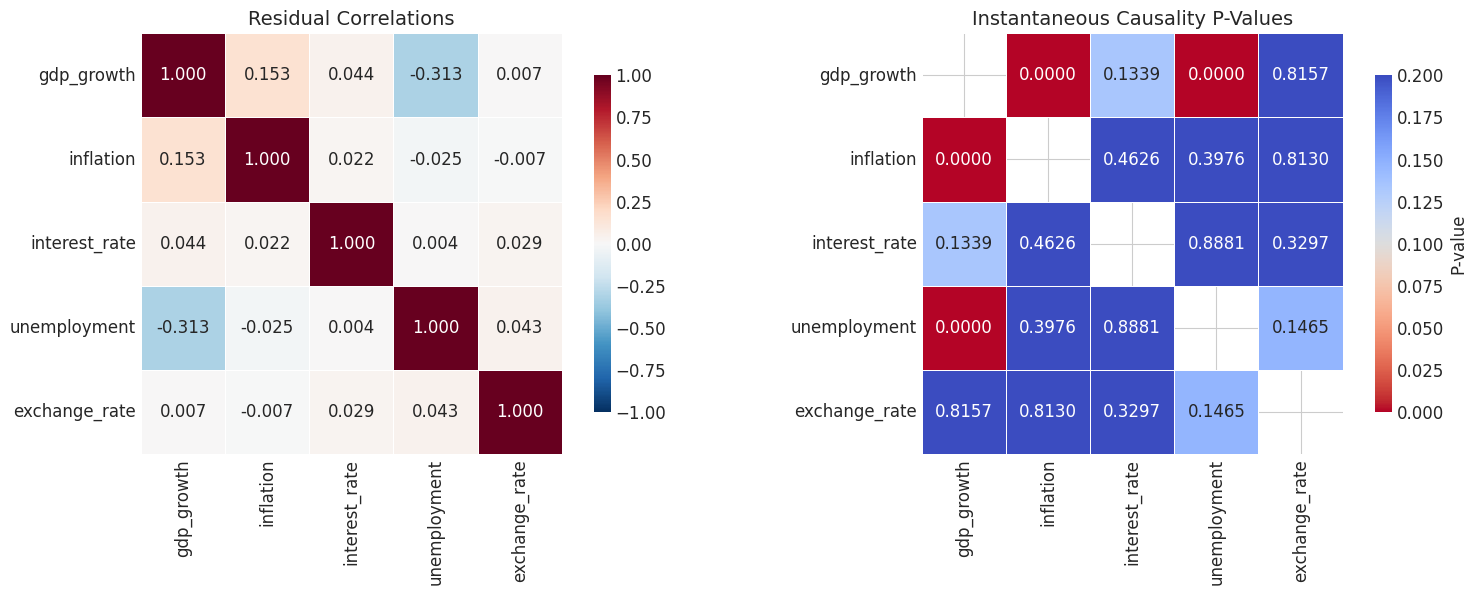

Instantaneous causality heatmaps and tables saved.


In [25]:
# Visualize: side-by-side correlation and p-value heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    square=True,
    ax=axes[0],
    cbar_kws={'shrink': 0.8},
)
axes[0].set_title('Residual Correlations', fontsize=14)

# P-value heatmap
mask_diag = np.eye(len(pval_matrix), dtype=bool)
sns.heatmap(
    pval_matrix,
    annot=True,
    fmt='.4f',
    cmap='coolwarm_r',
    vmin=0,
    vmax=0.20,
    mask=mask_diag,
    linewidths=0.5,
    square=True,
    ax=axes[1],
    cbar_kws={'shrink': 0.8, 'label': 'P-value'},
)
axes[1].set_title('Instantaneous Causality P-Values', fontsize=14)

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, '04_instantaneous_causality_heatmaps.png'),
            dpi=150, bbox_inches='tight')
plt.show()

# Save tables
corr_matrix.to_csv(os.path.join(TABLES_DIR, '04_instantaneous_correlation_matrix.csv'))
pval_matrix.to_csv(os.path.join(TABLES_DIR, '04_instantaneous_pvalue_matrix.csv'))
print('Instantaneous causality heatmaps and tables saved.')

### 6.3 Lagged vs Contemporaneous Causality

It is informative to compare which pairs exhibit lagged (Granger) causality versus contemporaneous (instantaneous) causality. A pair might show one, both, or neither.

In [26]:
# Compare lagged (Granger) vs instantaneous causality for all pairs
alpha = 0.05
comparison_results = []

for i, var1 in enumerate(endog_vars):
    for j, var2 in enumerate(endog_vars):
        if i >= j:
            continue  # Only upper triangle for instantaneous (symmetric)
        
        # Granger: test both directions
        gc_12 = gc_matrix.loc[var1, var2]
        gc_21 = gc_matrix.loc[var2, var1]
        
        # Instantaneous
        ic_pval = pval_matrix.loc[var1, var2]
        ic_corr = corr_matrix.loc[var1, var2]
        
        granger_12 = pd.notna(gc_12) and gc_12 < alpha
        granger_21 = pd.notna(gc_21) and gc_21 < alpha
        instant = pd.notna(ic_pval) and ic_pval < alpha
        
        comparison_results.append({
            'Pair': f'{var1} <-> {var2}',
            f'{var1}->{var2}': granger_12,
            f'{var2}->{var1}': granger_21,
            'Instantaneous': instant,
            'Correlation': ic_corr,
        })

comp_ic_df = pd.DataFrame(comparison_results)

print('Lagged (Granger) vs Instantaneous Causality')
print('=' * 80)
print(comp_ic_df.to_string(index=False))
print('=' * 80)
print()
print('Note: Granger causality is directional (A->B may differ from B->A),')
print('      while instantaneous causality is symmetric (correlation-based).')

Lagged (Granger) vs Instantaneous Causality
                           Pair gdp_growth->inflation inflation->gdp_growth  Instantaneous  Correlation gdp_growth->interest_rate interest_rate->gdp_growth gdp_growth->unemployment unemployment->gdp_growth gdp_growth->exchange_rate exchange_rate->gdp_growth inflation->interest_rate interest_rate->inflation inflation->unemployment unemployment->inflation inflation->exchange_rate exchange_rate->inflation interest_rate->unemployment unemployment->interest_rate interest_rate->exchange_rate exchange_rate->interest_rate unemployment->exchange_rate exchange_rate->unemployment
       gdp_growth <-> inflation                  True                 False           True     0.153357                       NaN                       NaN                      NaN                      NaN                       NaN                       NaN                      NaN                      NaN                     NaN                     NaN                      NaN

---

## Section 7: Best Practices and Pitfalls (15 min)

### 7.1 Key Pitfalls

| Pitfall | Description | Mitigation |
|---------|-------------|------------|
| **Granger != Structural** | Granger causality is predictive, not structural | Use structural VARs (SVAR) for causal claims |
| **Lag selection matters** | Results can change substantially with different lag lengths | Test sensitivity to lag choice; use information criteria |
| **Stationarity** | Standard Granger test assumes stationary data | Test for unit roots; use first differences or VECM if needed |
| **Omitted variables** | Missing variables can create spurious Granger causality | Include all relevant variables in the VAR |
| **Multiple testing** | Testing K(K-1) pairs inflates Type I error | Apply Bonferroni or BH correction |
| **Small T bias** | DH test requires sufficient T per entity | Check T > K*p + 2 for each entity |

### 7.2 Multiple Testing Correction

With K=5 variables, we test K(K-1) = 20 pairs. At 5% significance, we expect 1 false rejection even if no true causality exists. The **Bonferroni correction** adjusts for this.

In [27]:
# Multiple testing correction: Bonferroni
K = results.K
n_tests = K * (K - 1)  # Number of pairwise tests (excluding diagonal)
alpha_nominal = 0.05
alpha_bonferroni = alpha_nominal / n_tests

print(f'Number of variables (K): {K}')
print(f'Number of pairwise tests: {n_tests}')
print(f'Nominal significance level: {alpha_nominal}')
print(f'Bonferroni-corrected level: {alpha_bonferroni:.4f}')
print()

# Count significant results at both levels
sig_nominal = (gc_matrix < alpha_nominal).sum().sum()
sig_bonferroni = (gc_matrix < alpha_bonferroni).sum().sum()

print(f'Significant at nominal {alpha_nominal}: {sig_nominal} / {n_tests} pairs')
print(f'Significant at Bonferroni {alpha_bonferroni:.4f}: {sig_bonferroni} / {n_tests} pairs')
print()

# Show which survive Bonferroni correction
if sig_bonferroni > 0:
    print('Relationships surviving Bonferroni correction:')
    for cause_var in gc_matrix.index:
        for effect_var in gc_matrix.columns:
            pval = gc_matrix.loc[cause_var, effect_var]
            if pd.notna(pval) and pval < alpha_bonferroni:
                print(f'  {cause_var:>16s} -> {effect_var:<16s}  p = {pval:.6f}')
else:
    print('No relationships survive Bonferroni correction.')
    print('This does not mean no causality exists -- Bonferroni is conservative.')

Number of variables (K): 5
Number of pairwise tests: 20
Nominal significance level: 0.05
Bonferroni-corrected level: 0.0025

Significant at nominal 0.05: 8 / 20 pairs
Significant at Bonferroni 0.0025: 5 / 20 pairs

Relationships surviving Bonferroni correction:
        gdp_growth -> interest_rate     p = 0.000100
        gdp_growth -> unemployment      p = 0.000000
         inflation -> interest_rate     p = 0.000000
     interest_rate -> gdp_growth        p = 0.000000
     interest_rate -> exchange_rate     p = 0.000130


### 7.3 Comprehensive Summary Table

Let us use the `granger_causality_summary` utility to produce a complete summary of all pairwise tests.

In [28]:
# Use the utility function for a comprehensive summary
summary_df = granger_causality_summary(results, significance=0.05)

print('Complete Granger Causality Summary (sorted by p-value):')
print('=' * 75)
print(summary_df.to_string(index=False))
print('=' * 75)
print(f'\nSignificant at 5%: {summary_df["significant"].sum()} / {len(summary_df)} pairs')

# Save summary table
summary_df.to_csv(os.path.join(TABLES_DIR, '04_granger_causality_summary.csv'), index=False)
print('Summary table saved.')

Complete Granger Causality Summary (sorted by p-value):
        cause        effect  wald_stat      p_value  significant
    inflation interest_rate 135.786093 0.000000e+00         True
   gdp_growth  unemployment  56.372562 5.738743e-13         True
interest_rate    gdp_growth  37.215012 8.295888e-09         True
   gdp_growth interest_rate  18.427804 9.964448e-05         True
interest_rate exchange_rate  17.895562 1.300254e-04         True
interest_rate  unemployment   8.111294 1.732427e-02         True
   gdp_growth     inflation   7.925040 1.901513e-02         True
   gdp_growth exchange_rate   7.019055 2.991105e-02         True
    inflation  unemployment   3.923316 1.406251e-01        False
 unemployment     inflation   3.179485 2.039782e-01        False
interest_rate     inflation   3.022365 2.206490e-01        False
    inflation    gdp_growth   2.726733 2.557982e-01        False
    inflation exchange_rate   2.686183 2.610374e-01        False
 unemployment interest_rate   0.90

### 7.4 Sensitivity to Lag Length

Best practice: check whether conclusions change when you vary the lag order.

In [29]:
# Test sensitivity to lag order for a key relationship
test_cause = 'inflation'
test_effect = 'interest_rate'

lag_sensitivity = []
for p_lags in [1, 2, 3, 4]:
    try:
        var_data_p = PanelVARData(
            df,
            endog_vars=endog_vars,
            entity_col='country',
            time_col='quarter',
            lags=p_lags,
        )
        model_p = PanelVAR(var_data_p)
        results_p = model_p.fit(method='ols', cov_type='clustered')
        
        gc_p = results_p.granger_causality(cause=test_cause, effect=test_effect)
        
        lag_sensitivity.append({
            'Lags': p_lags,
            'Wald': gc_p.wald_stat,
            'df': gc_p.df,
            'p-value': gc_p.p_value,
            'Significant (5%)': gc_p.p_value < 0.05,
            'Stable': results_p.is_stable(),
        })
    except Exception as e:
        print(f'  Lag {p_lags}: Error - {e}')

lag_df = pd.DataFrame(lag_sensitivity)

print(f'Lag Sensitivity Analysis: {test_cause} -> {test_effect}')
print('=' * 65)
print(lag_df.to_string(index=False))
print('=' * 65)

if lag_df['Significant (5%)'].all():
    print('\nResult is ROBUST: significant at all lag lengths tested.')
elif lag_df['Significant (5%)'].any():
    print('\nResult is SENSITIVE to lag choice: significance varies across lags.')
else:
    print('\nResult is consistently NOT significant across lag lengths.')

# Save sensitivity table
lag_df.to_csv(os.path.join(TABLES_DIR, '04_lag_sensitivity.csv'), index=False)
print('Lag sensitivity table saved.')

Lag Sensitivity Analysis: inflation -> interest_rate
 Lags       Wald  df  p-value  Significant (5%)  Stable
    1 108.523263   1      0.0              True    True
    2 135.786093   2      0.0              True    True
    3 119.360807   3      0.0              True    True
    4 141.078740   4      0.0              True    True

Result is ROBUST: significant at all lag lengths tested.
Lag sensitivity table saved.


---

## Summary

### Key Takeaways

1. **Granger causality** tests whether lags of one variable improve prediction of another. It is about **predictive content**, not structural causation.

2. The **standard Wald test** assumes homogeneous coefficients across entities. It is simple and powerful when the homogeneity assumption holds.

3. The **Granger causality matrix** (K x K p-values) provides a complete overview of all pairwise relationships. Heatmaps and network plots make interpretation easier.

4. The **Dumitrescu-Hurlin test** allows for heterogeneous coefficients across entities. It is more appropriate when countries may have different causal dynamics.

5. **Network visualizations** reveal the causal structure at a glance. Centrality measures identify the most influential variables.

6. **Instantaneous causality** captures contemporaneous co-movement in VAR residuals, complementing the lagged Granger analysis.

7. **Best practices** include: checking lag sensitivity, applying multiple testing corrections, and always remembering that Granger-cause is not the same as structural cause.

### Next Steps

- **Tutorial 05**: VECM for cointegrated systems
- **Tutorial 06**: GMM for dynamic panel VAR

---

## Exercises

### Exercise 1: Complete Causality Matrix (Easy)

Using the fitted `results` object:

1. Compute the Granger causality matrix at a 10% significance level
2. Count how many additional causal relationships appear compared to 5%
3. Create a heatmap with the 10% threshold

**Hint:** Use `results.granger_causality_matrix(significance_level=0.10)` and compare with the earlier 5% matrix.

In [30]:
# YOUR CODE HERE
# gc_matrix_10 = results.granger_causality_matrix(significance_level=0.10)
# sig_5 = (gc_matrix < 0.05).sum().sum()
# sig_10 = (gc_matrix_10 < 0.10).sum().sum()
# print(f'Additional relationships at 10% vs 5%: {sig_10 - sig_5}')

### Exercise 2: Homogeneous Wald vs DH Test (Medium)

1. Pick 3 variable pairs from the macro panel
2. Run both the standard Wald test and the DH test on each
3. Create a table comparing the results
4. Discuss: in which cases do the tests disagree? What might explain the disagreement?

**Hint:** Use `results.granger_causality(cause=..., effect=...)` and `results.dumitrescu_hurlin(cause=..., effect=...)`.

In [31]:
# YOUR CODE HERE
# pairs = [('gdp_growth', 'inflation'), ('interest_rate', 'exchange_rate'), ('unemployment', 'gdp_growth')]
# for cause, effect in pairs:
#     gc = results.granger_causality(cause=cause, effect=effect)
#     dh = results.dumitrescu_hurlin(cause=cause, effect=effect)
#     print(f'{cause} -> {effect}:')
#     print(f'  Wald p = {gc.p_value:.4f}, DH p = {dh.Z_bar_pvalue:.4f}')

### Exercise 3: Centrality Analysis (Medium)

1. Build the Granger causality network graph (using networkx)
2. Compute the **betweenness centrality** of each node (hint: `nx.betweenness_centrality(G)`)
3. Which variable is the most "central" in the causal network?
4. Interpret: what does high betweenness centrality mean economically?

**Hint:** Betweenness centrality measures how often a node lies on the shortest path between other pairs of nodes.

In [32]:
# YOUR CODE HERE
# betweenness = nx.betweenness_centrality(G)
# for var, score in sorted(betweenness.items(), key=lambda x: x[1], reverse=True):
#     print(f'  {var}: {score:.4f}')

### Exercise 4: Instantaneous Causality Deep Dive (Medium)

1. For all pairs where Granger causality is significant but instantaneous causality is not, and vice versa, discuss the economic interpretation
2. Create a scatter plot of Granger p-values vs instantaneous p-values for all pairs
3. Are lagged and contemporaneous relationships correlated?

**Hint:** Use the `gc_matrix` and `pval_matrix` computed in the tutorial.

In [33]:
# YOUR CODE HERE
# Collect all pairwise p-values into a scatter plot
# granger_pvals = []
# instant_pvals = []
# for i, var1 in enumerate(endog_vars):
#     for j, var2 in enumerate(endog_vars):
#         if i >= j:
#             continue
#         granger_pvals.append(gc_matrix.loc[var1, var2])
#         instant_pvals.append(pval_matrix.loc[var1, var2])
# plt.scatter(granger_pvals, instant_pvals)
# plt.xlabel('Granger p-value')
# plt.ylabel('Instantaneous p-value')
# plt.title('Lagged vs Contemporaneous Causality')
# plt.show()

### Exercise 5: Trade Panel Causality Network (Hard)

Using the trade panel data (generated from `generate_trade_panel()`):

1. Generate the trade panel dataset
2. Estimate a Panel VAR with variables: exports, imports, gdp, fdi_inflows
3. Compute the Granger causality matrix
4. Run DH tests for all pairs
5. Create a causality network visualization
6. Identify the most influential variable in the trade network

**Hints:**
- The trade panel uses `entity_col='country'` and `time_col='year'`
- The `year` column contains integers (strings are fine too -- do NOT convert to datetime)
- Start with lags=1 for simplicity

In [34]:
# YOUR CODE HERE
# Step 1: Generate data
# trade_df = generate_trade_panel()
# print(f'Trade panel: {trade_df.shape}')
# print(trade_df.head())
#
# Step 2: Estimate Panel VAR
# trade_vars = ['exports', 'imports', 'gdp', 'fdi_inflows']
# trade_data = PanelVARData(
#     trade_df,
#     endog_vars=trade_vars,
#     entity_col='country',
#     time_col='year',
#     lags=1,
# )
# trade_model = PanelVAR(trade_data)
# trade_results = trade_model.fit(method='ols', cov_type='clustered')
#
# Step 3: Granger causality matrix
# trade_gc = trade_results.granger_causality_matrix()
# print(trade_gc.round(4))
#
# Step 4: Network plot
# trade_results.plot_causality_network(
#     threshold=0.05, layout='circular', backend='matplotlib', show=True
# )

---

## References

- Granger, C. W. J. (1969). "Investigating Causal Relations by Econometric Models and Cross-spectral Methods." *Econometrica*, 37(3), 424-438.
- Dumitrescu, E. I., & Hurlin, C. (2012). "Testing for Granger non-causality in heterogeneous panels." *Economic Modelling*, 29(4), 1450-1460.
- Holtz-Eakin, D., Newey, W., & Rosen, H. S. (1988). "Estimating Vector Autoregressions with Panel Data." *Econometrica*, 56(6), 1371-1395.
- Abrigo, M. R., & Love, I. (2016). "Estimation of Panel Vector Autoregression in Stata." *The Stata Journal*, 16(3), 778-804.